In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [31]:
# Read the Excel file into a DataFrame
df_train = pd.read_csv('acc_gyr.csv')

In [32]:
df_train.head()   #first 5 rows of the data

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall


In [33]:
df_train.shape

(96800, 7)

In [34]:
df_train.isnull().sum()

xAcc     0
yAcc     0
zAcc     0
xGyro    0
yGyro    0
zGyro    0
label    0
dtype: int64

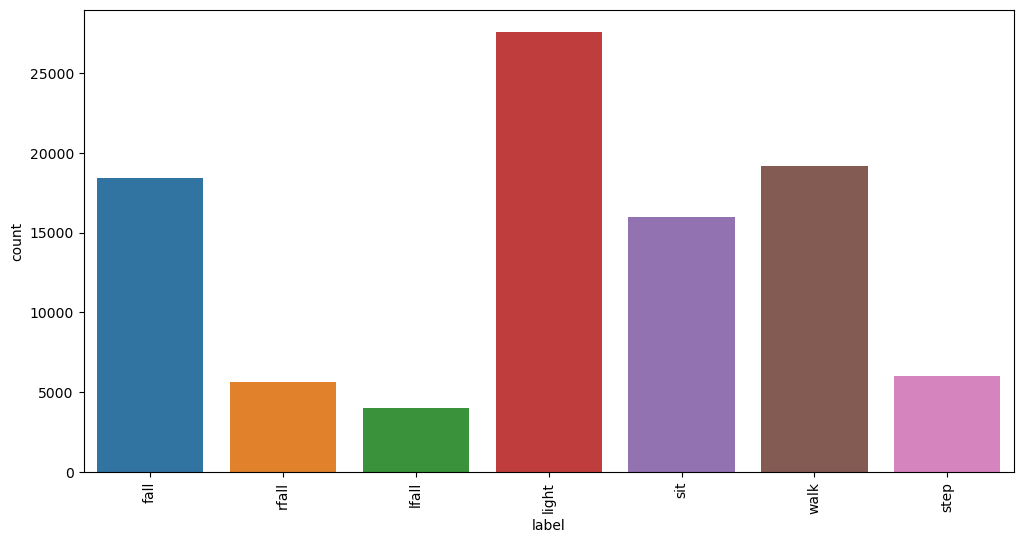

In [35]:
#Now Visualize the class Distribution

plt.figure(figsize=(12,6))
axis=sns.countplot(x="label",data=df_train)
plt.xticks(x=df_train['label'],rotation='vertical')
plt.show()

In [36]:
# Define the column and the string values to look for
column_to_delete_from = 'label'
values_to_match = ('fall', 'light', 'sit', 'walk')

# Define the proportion of rows to delete
proportion_to_delete = 0.7  # 70% of the matching rows

# Filter rows where the column matches any of the string values
matching_indices = df_train[df_train[column_to_delete_from].isin(values_to_match)].index

# Debugging: print the matching indices
print("\nMatching indices where column '{}' equals '{}':".format(column_to_delete_from, values_to_match))
print(matching_indices)

# Calculate the number of rows to delete
num_rows_to_delete = int(np.ceil(proportion_to_delete * len(matching_indices)))

# Debugging: print the number of rows to delete
print("\nNumber of rows to delete:", num_rows_to_delete)

# Check if there are rows to delete
if num_rows_to_delete > 0:
    # Randomly select indices from the matching indices
    indices_to_delete = np.random.choice(matching_indices, size=num_rows_to_delete, replace=False)

    # Debugging: print the indices to delete
    print("\nIndices to delete:")
    print(indices_to_delete)

    # Drop the selected rows
    df_train = df_train.drop(indices_to_delete)

# Print the modified DataFrame
print("\nDataFrame after randomly deleting rows where column '{}' equals '{}':".format(column_to_delete_from, values_to_match))
print(df_train)



Matching indices where column 'label' equals '('fall', 'light', 'sit', 'walk')':
Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       96790, 96791, 96792, 96793, 96794, 96795, 96796, 96797, 96798, 96799],
      dtype='int64', length=81201)

Number of rows to delete: 56841

Indices to delete:
[15018 36702 95248 ... 13007 34290 41175]

DataFrame after randomly deleting rows where column 'label' equals '('fall', 'light', 'sit', 'walk')':
       xAcc  yAcc  zAcc  xGyro  yGyro  zGyro  label
2      6.22 -0.63 -6.73   0.79  -5.49   3.85   fall
6      6.27 -1.34 -6.97  -2.99   3.85  -1.28   fall
7      6.67 -1.01 -7.20  -5.31   5.37   0.98   fall
16     6.52 -0.57 -7.24 -17.46   3.30  15.50   fall
19     6.71 -0.03 -6.92   2.87  -0.18  -7.93   fall
...     ...   ...   ...    ...    ...    ...    ...
96790  7.67  1.05 -2.50  52.80  -2.93 -47.67  light
96792  8.10 -3.34 -7.43  45.23  -7.14 -46.45  light
96794  7.50 -1.83 -5.54  19.90   7.26 -32.04  ligh

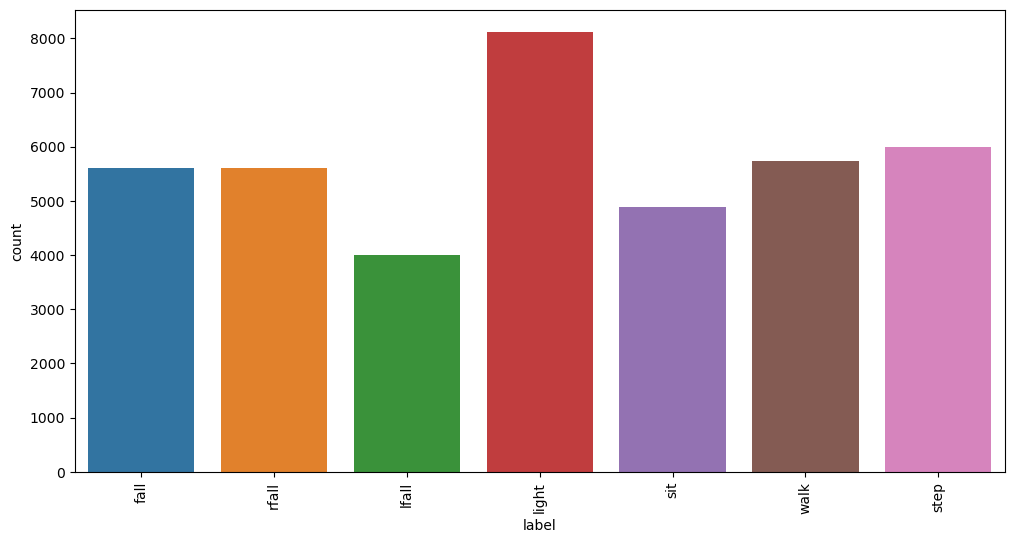

In [37]:
#Now Visualize the class Distribution

plt.figure(figsize=(12,6))
axis=sns.countplot(x="label",data=df_train)
plt.xticks(x=df_train['label'],rotation='vertical')
plt.show()

In [38]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
xAcc,39959.0,7.090797,3.140676,-39.24,5.63,6.90,8.29,39.24
yAcc,39959.0,-1.343018,3.170424,-39.24,-2.87,-1.20,0.39,39.24
zAcc,39959.0,-2.410759,5.825440,-39.24,-6.14,-4.61,-0.87,39.24
xGyro,39959.0,-1.202972,34.273723,-483.40,-12.57,-0.49,10.99,439.39
yGyro,39959.0,-0.641079,24.752708,-406.25,-6.23,0.31,7.02,317.38
zGyro,39959.0,0.016115,28.510281,-354.00,-10.99,-0.92,11.90,299.19


In [39]:
# Encode the labels
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])

# Scale the features
scaler = StandardScaler()
features = df_train[['xAcc', 'yAcc', 'zAcc', 'xGyro', 'yGyro', 'zGyro']]
features_scaled = scaler.fit_transform(features)

In [40]:
print(df_train['label'].unique())

[0 3 1 2 4 6 5]


In [41]:
# Prepare the sequences
def create_sequences(features, labels, seq_length=10):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x_seq = features[i:i + seq_length]
        y_seq = labels.iloc[i + seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(features_scaled, df_train['label'], seq_length)

In [42]:
# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=len(label_encoder.classes_))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 6), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
# model.save('sensor_model.h5')

import pickle
import joblib

with open('sensor_model_architecture.pkl', 'wb') as f:
    pickle.dump(model.to_json(), f)

model.save_weights('sensor_model.weights.h5')

# Save the scaler and label encoder
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Accuracy: {accuracy*100:.2f}%")

Epoch 1/10


C:\Users\THE LAPTOP SHOP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


799/799 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.5118 - loss: 1.2685 - val_accuracy: 0.6974 - val_loss: 0.8062
Epoch 2/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7116 - loss: 0.7588 - val_accuracy: 0.7444 - val_loss: 0.6620
Epoch 3/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7610 - loss: 0.6176 - val_accuracy: 0.7786 - val_loss: 0.5664
Epoch 4/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7943 - loss: 0.5309 - val_accuracy: 0.8057 - val_loss: 0.5012
Epoch 5/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8204 - loss: 0.4599 - val_accuracy: 0.8148 - val_loss: 0.4622
Epoch 6/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8386 - loss: 0.4098 - val_accuracy: 0.8393 - val_loss: 0.4129
Epoch 7/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8625 - loss: 0.3594 - val_accuracy: 0.8434 - val_loss: 0.3992
Epoch 8/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8738 - loss: 0.3263 - val_accurac